In [ ]:
from src.backtester import Order
import numpy as np

class Trader:
    def __init__(self):
        self.position_limit = 20
        self.order_size = 2
        self.spread = 8.0
        self.risk_aversion = 0.25
        self.sma_period = 40
        self.momentum_window = 10
        self.min_spread_threshold = 1.5

        self.price_history = []

    def run(self, state, current_position):
        result = {}
        product = "PRODUCT"
        orders = []
        order_depth = state.order_depth

        if not order_depth.buy_orders or not order_depth.sell_orders:
            return result

        best_bid = max(order_depth.buy_orders)
        best_ask = min(order_depth.sell_orders)
        mid_price = (best_bid + best_ask) / 2
        spread = best_ask - best_bid

        if spread < self.min_spread_threshold:
            return result

        # Maintain price history
        self.price_history.append(mid_price)
        if len(self.price_history) > self.sma_period:
            self.price_history.pop(0)

        # Wait till enough history is available
        if len(self.price_history) < self.sma_period:
            return result

        fair_value = np.mean(self.price_history)

        # Trend filter: skip trading during strong directional moves
        if len(self.price_history) >= self.momentum_window:
            recent_prices = self.price_history[-self.momentum_window:]
            momentum = recent_prices[-1] - recent_prices[0]
            if abs(momentum) > 3:  # adjust this threshold as needed
                return result  # sit out during trend moves

        # Inventory skew adjustment
        inventory_skew = current_position / self.position_limit
        our_bid = round(fair_value - self.spread / 2 - inventory_skew * self.risk_aversion)
        our_ask = round(fair_value + self.spread / 2 - inventory_skew * self.risk_aversion)

        # Place buy order if space
        if current_position < self.position_limit:
            buy_qty = min(self.order_size, self.position_limit - current_position)
            orders.append(Order(product, our_bid, buy_qty))

        # Place sell order if space
        if current_position > -self.position_limit:
            sell_qty = min(self.order_size, self.position_limit + current_position)
            orders.append(Order(product, our_ask, -sell_qty))

        result[product] = orders
        return result


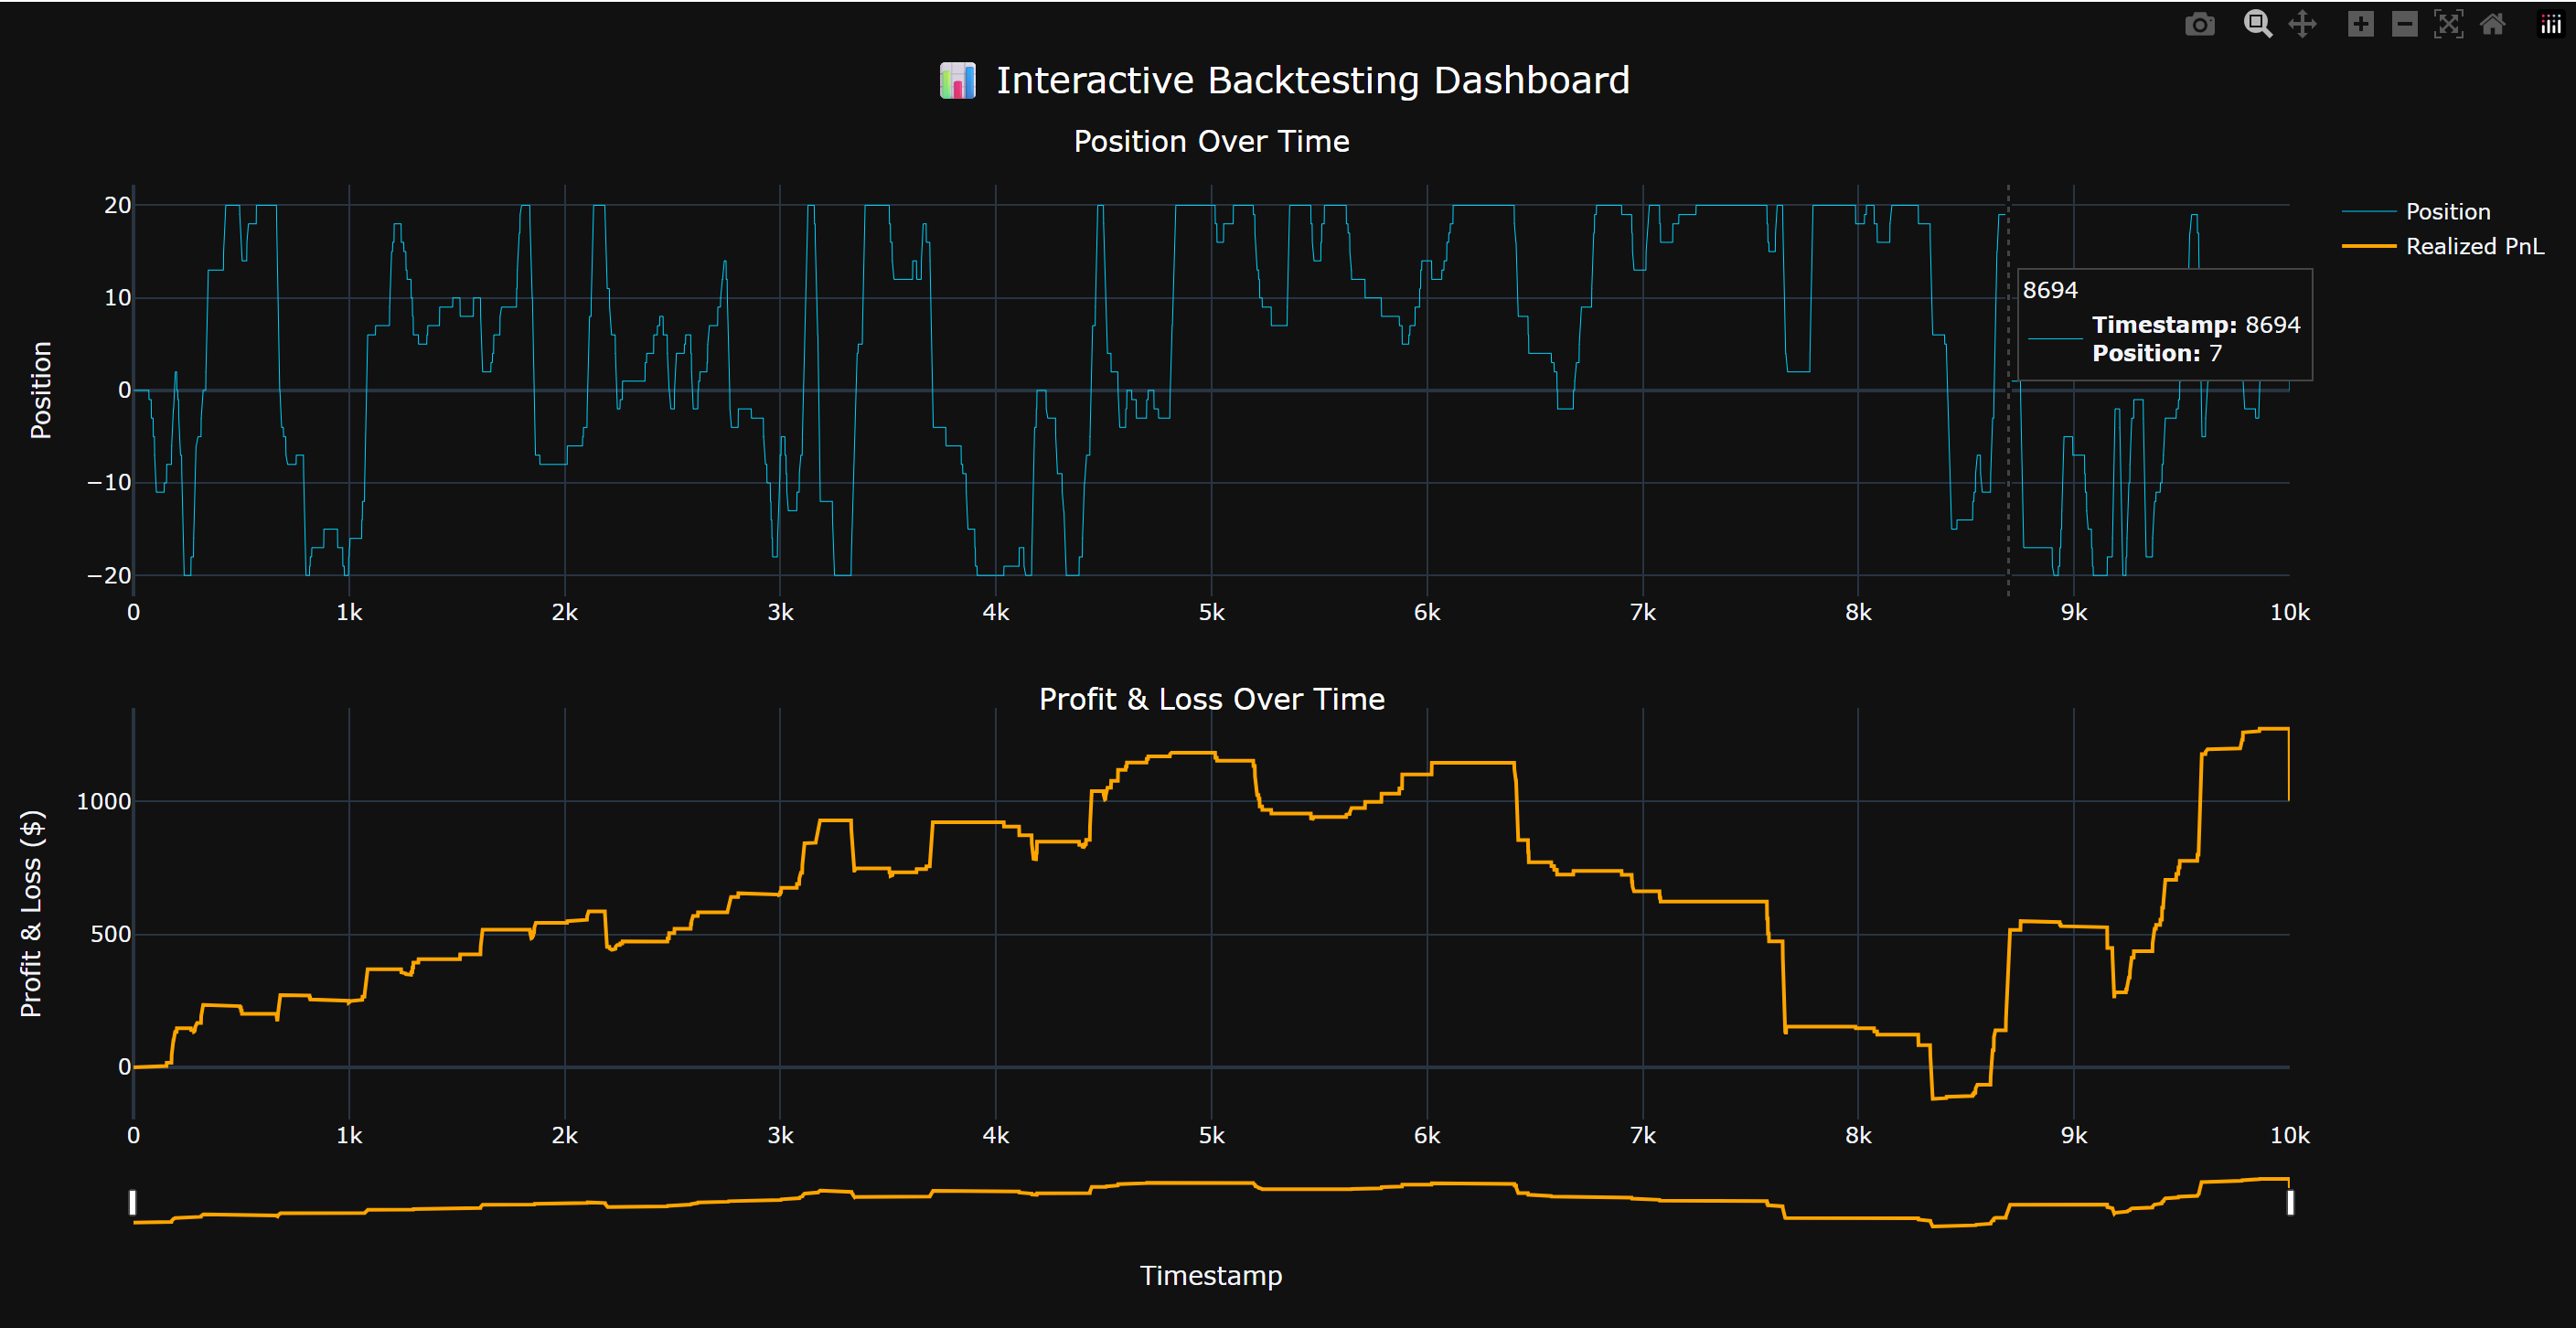

In [1]:
from IPython.display import Image, display

display(Image(filename='ABRA.png'))
